In [1]:
# import
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import zipcodes
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

In [2]:
# read zillow data
with open('../data/Zip_Zhvi_SingleFamilyResidence.csv', 'rb') as f:
    df_zillow = pd.read_csv(f).fillna(0)

# read unemployment data
with open('../data/laucnty17.xlsx', 'rb') as f:
    df_labor = pd.read_excel(f, skiprows=range(1, 6)).fillna(0)

# read crime data
with open('../data/district-of-columbia.xls', 'rb') as f:
    df_crime_dc = pd.read_excel(f, skiprows=range(1, 2)).fillna(0)

with open('../data/maryland.xls', 'rb') as f:
    df_crime_md = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/massachusetts.xls', 'rb') as f:
    df_crime_ma = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/virginia.xls', 'rb') as f:
    df_crime_va = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

with open('../data/new-hampshire.xls', 'rb') as f:
    df_crime_nh = pd.read_excel(f, skiprows=range(1, 5)).fillna(0)

In [3]:
# crime columns
#dc_col_list = df_crime_dc.iloc[:, 3:12].columns.tolist()
md_col_list = df_crime_md.iloc[:, 3:12].columns.tolist()
ma_col_list = df_crime_ma.iloc[:, 3:12].columns.tolist()
va_col_list = df_crime_va.iloc[:, 3:12].columns.tolist()
nh_col_list = df_crime_nh.iloc[:, 3:12].columns.tolist()

# crime sum: simplified by summing all offense types
#dc_sum = df_crime_dc[dc_col_list].sum(axis=1)
md_sum = df_crime_md[md_col_list].sum(axis=1)
ma_sum = df_crime_ma[ma_col_list].sum(axis=1)
va_sum = df_crime_va[va_col_list].sum(axis=1)
nh_sum = df_crime_nh[nh_col_list].sum(axis=1)

# crime ratio: offense sum / population
df_md = df_crime_md
df_md['City'] = df_crime_md.iloc[:, 0]
df_md['State'] = 'md'
df_md['Population'] = df_crime_md.iloc[:, 1]
df_md['CrimeRatio'] = md_sum/df_crime_md.iloc[:, 1]
df_md = df_crime_md[['City', 'Population', 'CrimeRatio', 'State']]

df_ma = df_crime_ma
df_ma['City'] = df_crime_ma.iloc[:, 0]
df_ma['State'] = 'ma'
df_ma['Population'] = df_crime_ma.iloc[:, 1]
df_ma['CrimeRatio'] = ma_sum/df_crime_ma.iloc[:, 1]
df_ma = df_crime_ma[['City', 'Population', 'CrimeRatio', 'State']]

df_va = df_crime_va
df_va['City'] = df_crime_va.iloc[:, 0]
df_va['State'] = 'va'
df_va['Population'] = df_crime_va.iloc[:, 1]
df_va['CrimeRatio'] = va_sum/df_crime_va.iloc[:, 1]
df_va = df_crime_va[['City', 'Population', 'CrimeRatio', 'State']]

df_nh = df_crime_nh
df_nh['City'] = df_crime_nh.iloc[:, 0]
df_nh['State'] = 'nh'
df_nh['Population'] = df_crime_nh.iloc[:, 1]
df_nh['CrimeRatio'] = nh_sum/df_crime_nh.iloc[:, 1]
df_nh = df_crime_nh[['City', 'Population', 'CrimeRatio', 'State']]

# combine dataframe
df_crime = pd.concat([df_md, df_ma, df_va, df_nh])

# remove unneeded column
df_crime.drop(['Population'], axis=1, inplace=True)

# convert to lowercase
df_crime[['City', 'State']] = df_crime[['City', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

In [4]:
# restructure labor columns
df_labor = pd.DataFrame(df_labor.iloc[:, [3,9]])
df_labor.columns = ['Location', 'Unemployment']
df_labor[['CountyName', 'State']] = df_labor['Location'].str.split(',', expand=True)
df_labor.drop(['Location'], axis=1, inplace=True)

In [5]:
# convert non-timeseries
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].astype(str)
df_zillow[['RegionID', 'RegionName', 'SizeRank']] = df_zillow[['RegionID', 'RegionName', 'SizeRank']].astype(int)

# convert to lowercase
df_zillow[['City', 'State', 'Metro', 'CountyName']] = df_zillow[['City', 'State', 'Metro', 'CountyName']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)
df_labor[['CountyName', 'State']] = df_labor[['CountyName', 'State']].apply(
  lambda x: x.astype(str).str.lower().map(lambda x: x.strip())
)

# remove redundant suffix
df_labor[['CountyName']] = df_labor['CountyName'].str.rstrip('county').map(lambda x: x.strip())

In [6]:
# arkansas metro areas
hot_springs = df_zillow.loc[(df_zillow['Metro'] == 'hot springs') & (df_zillow['State'] == 'ar')]
little_rock = df_zillow.loc[(df_zillow['Metro'] == 'little rock') & (df_zillow['State'] == 'ar')]
fayetteville = df_zillow.loc[(df_zillow['Metro'] == 'fayetteville') & (df_zillow['State'] == 'ar')]
searcy = df_zillow.loc[(df_zillow['Metro'] == 'searcy') & (df_zillow['State'] == 'ar')]

In [7]:
# merge dataframes
df = pd.merge(df_zillow, df_labor, on=['CountyName', 'State'])
df = pd.merge(df, df_crime, on=['City', 'State'])

# timeseries data
ts_start = df.columns.get_loc('1996-04') + 1
ts_end = df.columns.get_loc('2017-09')
date_columns = df.iloc[:, ts_start:ts_end].columns.tolist()

# ensure integer timeseries
df[date_columns] = df[date_columns].astype(int)

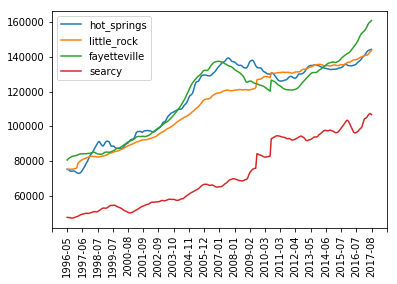

In [8]:
# timeseries plot
fig, ax = plt.subplots()
ax.plot(hot_springs[date_columns].mean(), linestyle='solid')
ax.plot(little_rock[date_columns].mean(), linestyle='solid')
ax.plot(fayetteville[date_columns].mean(), linestyle='solid')
ax.plot(searcy[date_columns].mean(), linestyle='solid')

# decrease ticks
xmin, xmax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))

# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('hot_springs', 'little_rock', 'fayetteville', 'searcy'))

# show overall plot
plt.show()

In [9]:
# remove rows with unemployment >= 4.5%
df = df[df.Unemployment < 4.5]

# remove rows with crime >= 5%
df = df[df.CrimeRatio < 0.05]

# remove redundant columns
df.drop(['Unemployment'], axis=1, inplace=True)
df.drop(['CrimeRatio'], axis=1, inplace=True)

In [10]:
# filter specific states
df = df.loc[df['State'].isin(['md','va', 'nh', 'ma', 'dc'])]

# remove specific cities
df = df.loc[-((df['Metro'] == 'baltimore') & (df['State'] == 'md'))]

In [11]:
# train: collapse column by median
train_start = df.columns.get_loc('1997-01')
train_stop = df.columns.get_loc('2017-01')
test_stop = df.columns.get_loc('2017-09')
train_columns = df.iloc[:, train_start:train_stop].columns.tolist()
test_columns = df.iloc[:, (train_stop + 1):test_stop].columns.tolist()

In [12]:
# remove rows with 0's beginning (1997-01) with trainset
date_columns = df.iloc[:, train_start:test_stop].columns.tolist()

df[date_columns] = df[date_columns].replace(0, np.nan).dropna(
    axis=0,
    how='any',
    subset=date_columns
)

In [13]:
#
# transpose dataframe: left column data, right column value
#
#     date1  val1
#     date2  val2
#      ...   ...
#     daten  valn
#
df_train = df[train_columns].median().T
df_test = df[test_columns].median().T

#
# build arima model:
#
#     AR: autoregression, uses observations from previous time steps as input to
#         a regression equation to predict the value at the next time step.
#
#     I: integrated, use of differencing of raw observations, or subtracting an
#         observation from previous time step. The goal is to attain a time
#         series that is stationary.
#
#     MA: moving average, uses the dependency between an observation and a residual
#         error from a moving average model applied to lagged observations.
#
model = ARIMA(df_train, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  239
Model:                 ARIMA(5, 1, 3)   Log Likelihood               -1944.603
Method:                       css-mle   S.D. of innovations            817.439
Date:                Sun, 18 Nov 2018   AIC                           3909.207
Time:                        07:00:14   BIC                           3943.971
Sample:                    02-01-1997   HQIC                          3923.216
                         - 12-01-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        872.8122    726.445      1.201      0.231    -550.993    2296.618
ar.L1.D.y      0.8794      0.144      6.087      0.000       0.596       1.163
ar.L2.D.y     -0.9241      0.088    -10.484      0.0

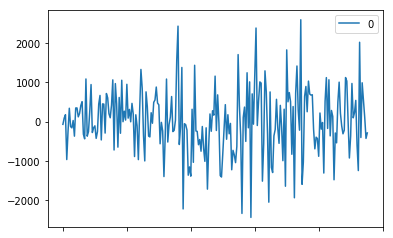

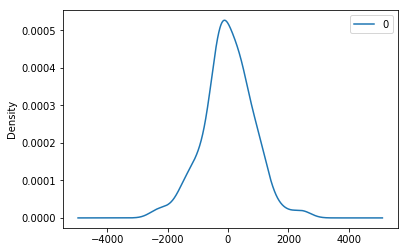

In [14]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# plot kernel density estimation
residuals.plot(kind='kde')
plt.show()

In [15]:
# descriptive statistics on residual
print(residuals.describe())

                 0
count   239.000000
mean     10.278937
std     824.347853
min   -2445.232639
25%    -403.627846
50%     -25.341565
75%     503.617710
max    2594.728769


In [16]:
#
# rolling prediction (verify model): month +2, since the train
#     includes 2017-01.
#
# Note: rolling prediction is required since there is an implicit
#       dependence on observations in prior time steps inheritted
#       when autogressive (AR) model was defined.
#
history = [x for x in df_train]
predictions = list()
iterations = (12-len(df_test)) + 18

for t in range(iterations):
    model = ARIMA(history, order=(5,1,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)

    if t > 10:
        year = 2018
        month = (t+2) % 12
        if month == 0:
            month = 12
    else:
        year = 2017
        month = t+2
        if month == 0:
            month = 12

    print('\n===============================================')
    print('date: {}-{:01d}'.format(year, month))
    print('-----------------------------------------------')

    #
    # observation: if current value doesn't exist from test, append current
    #     predition, to ensure successive rolling prediction computed.
    #
    try:
        obs = df_test[t]
        print('predicted={:03f}, expected={:03f}'.format(float(yhat), obs))
        print('prediction difference: {:03f}'.format(abs(1-float(yhat)/obs)))
        print('\n===============================================')
        error = mean_squared_error(df_test, predictions)
        print('Test MSE: {:03f}\n\n'.format(error))
    except:
        obs = yhat
        print('predicted={:03f}'.format(float(yhat)))

    history.append(obs)


date: 2017-2
-----------------------------------------------
predicted=352726.450154, expected=356350.000000
prediction difference: 0.010169

predicted=352726.450154

date: 2017-3
-----------------------------------------------
predicted=354688.606557, expected=357950.000000
prediction difference: 0.009111

predicted=354688.606557

date: 2017-4
-----------------------------------------------
predicted=356607.209790, expected=359250.000000
prediction difference: 0.007356

predicted=356607.209790

date: 2017-5
-----------------------------------------------
predicted=358585.696552, expected=357300.000000
prediction difference: 0.003598

predicted=358585.696552

date: 2017-6
-----------------------------------------------
predicted=360561.268206, expected=357700.000000
prediction difference: 0.007999

predicted=360561.268206

date: 2017-7
-----------------------------------------------
predicted=362407.134568, expected=358850.000000
prediction difference: 0.009913

predicted=362407.13456

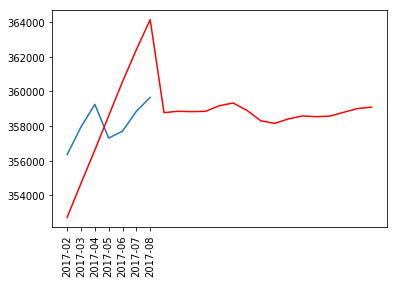

In [17]:
# plot rolling prediction
plt.plot(df_test)
plt.plot(predictions, color='red')
plt.xticks(rotation=90)
plt.show()

In [18]:
# stationarity test
def difference(dataset, delta):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - delta]
        diff.append(value)
    return pd.Series(diff)

def compute_arima(df_train):
    #
    # Note: rolling prediction is required since there is an implicit
    #       dependence on observations in prior time steps inheritted
    #       when autogressive (AR) model was defined.
    #
    history = [x for x in df_train]
    predictions = list()
    iterations = (12-len(df_test)) + 18

    for t in range(iterations):
        delta = 0
        model_fit = False

        #
        # determine stationarity value: no need to difference more than
        #     one third the length of the given series.
        #
        # @delta, the difference factor.
        #
        for delta in range(int(len(history) / 3)):
            stationary = difference(history, delta)
            stationary.index = history[1:]
            result = adfuller(stationary)
            print('delta: {}, p: {}'.format(delta, result[1]))

            #
            # generate model: use dickey-fuller significance test using
            #     custom 'difference' function. Sometimes, statsmodel's
            #     arima algorithm will not agree with our pvalue, so it
            #     is forced to search for another significant difference.
            #
            if (result[1] <= 0.05):
                try:
                    model = ARIMA(history, order=(delta, 1, 0))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('stationarity not adequate')
                    continue

        #
        # bad condition: no significant stationarity found on given delta,
        #     so have to pick any next one that works.
        #        
        if not model_fit:
            for delta2 in range(delta, len(history)):
                try:
                    model = ARIMA(history, order=(delta2, 1, 0))
                    model_fit = model.fit(disp=0)
                    break
                except:
                    print('bad condition {}: stationarity not adequate'.format(delta2))
                    continue

        #
        # generate forecast: some edge cases will not generate sufficient stationarity,
        #     This means successive rolling predictions will not occur. So, the model
        #     instance is not useful, and thrown out.
        #
        if model_fit:
            output = model_fit.forecast()
            yhat = output[0]
        else:
            predictions = [None]
            break

        #
        # observation: if current value doesn't exist from test, append current
        #     predition, to ensure successive rolling prediction computed.
        #
        try:
            obs = df_test[t]
        except:
            obs = yhat
        history.append(obs)
        
        predictions.append(yhat)
        print('predictions: {}'.format(predictions))

    return(predictions)

def get_zipcode(city, state):
    result = zipcodes.filter_by(
        zipcodes.list_all(),
        active=True,
        city=city,
        state=state
    )

    if result and result[0] and result[0]['zip_code']:
        return(result[0]['zip_code'])
    else:
        return(0)

In [19]:
# add zipcode column
df['zip_code'] = df[['City', 'State']].apply(
    lambda x: get_zipcode(
        x['City'].upper(),
        x['State'].upper()
    ),
    axis=1
)

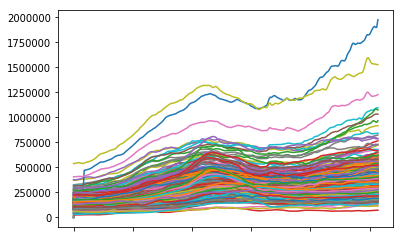

In [20]:
# group by zipcode
df_zipcode = df.groupby('zip_code').agg(np.median).dropna().T

#
# remove columns: column 0 indicates an NaN column
#
df_zipcode_clean = df_zipcode.drop([
    'RegionName',
    'RegionID',
    'SizeRank'
], axis=0)
df_zipcode_clean = df_zipcode_clean.drop([0], axis=1)

df_zipcode_clean.plot(legend=None)
plt.show()

In [ ]:
# iterate columns
results = []
for column in df_zipcode_clean:
    predictions = compute_arima(df_zipcode_clean[column])
    results.append({
        'zip_code': df_zipcode_clean[column].name,
        'predictions': predictions
    })

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:846: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\jeff1\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


delta: 0, p: nan
delta: 1, p: 0.43581480343739437
delta: 2, p: 0.09602268561265981
delta: 3, p: 0.12330830782157487
delta: 4, p: 0.13016438413596815
delta: 5, p: 0.10373052767375313
delta: 6, p: 0.1603877865387051
delta: 7, p: 0.042705747735187594
predictions: [array([344276.46559226])]
delta: 0, p: nan
delta: 1, p: 0.803479384907082
delta: 2, p: 0.5858174147921911
delta: 3, p: 0.4905951809167539
delta: 4, p: 0.6352038915219083
delta: 5, p: 0.5339802889265176
delta: 6, p: 0.5145835730456775
delta: 7, p: 0.2100479142753809
delta: 8, p: 0.09267183040773197
delta: 9, p: 1.2471231454619788e-29


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:607: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:609: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


stationarity not adequate
delta: 10, p: 1.4604156810534592e-13
stationarity not adequate
delta: 11, p: 1.6477981182476494e-08
stationarity not adequate
delta: 12, p: 4.605202027434386e-07


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: invalid value encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 13, p: 1.6784658726894765e-05
stationarity not adequate
delta: 14, p: 0.00017493294735077813
stationarity not adequate
delta: 15, p: 0.0008011813956004226
stationarity not adequate
delta: 16, p: 0.0016513958782894767
stationarity not adequate
delta: 17, p: 0.004728794228148145
stationarity not adequate
delta: 18, p: 0.00787740803839925
stationarity not adequate
delta: 19, p: 0.012472334031159184
stationarity not adequate
delta: 20, p: 0.017211455458611566
stationarity not adequate
delta: 21, p: 0.02123045492614434
stationarity not adequate
delta: 22, p: 0.026479834834731028
stationarity not adequate
delta: 23, p: 0.03311554993460933
stationarity not adequate
delta: 24, p: 0.03978599526936508
stationarity not adequate
delta: 25, p: 0.04707709828206484
stationarity not adequate
delta: 26, p: 0.05642998556212516
delta: 27, p: 0.06636855338753976
delta: 28, p: 0.0761968629675294
delta: 29, p: 0.08194203669061245
delta: 30, p: 0.0846733675581352
delta: 31, p

bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condition 214: stationarity not adequate
bad condition 215: stationarity not adequate
bad condition 216: stationarity not adequate
bad condition 217: stationarity not adequate
bad condition 218: stationarity not adequate
bad condition 219: stationarity not adequate
bad condition 220: stationarity not adequate
bad condition 221: stationarity not adequate
bad condition 222: stationarity not adequate
bad condition 223: stationarity not adequate
bad condition 224: stationarity not adequate
bad condition 225: stationarity not adequate
bad condition 226: stationarity not adequate
bad condition 227: stationarity not adequate
bad condit

bad condition 140: stationarity not adequate
bad condition 141: stationarity not adequate
bad condition 142: stationarity not adequate
bad condition 143: stationarity not adequate
bad condition 144: stationarity not adequate
bad condition 145: stationarity not adequate
bad condition 146: stationarity not adequate
bad condition 147: stationarity not adequate
bad condition 148: stationarity not adequate
bad condition 149: stationarity not adequate
bad condition 150: stationarity not adequate
bad condition 151: stationarity not adequate
bad condition 152: stationarity not adequate
bad condition 153: stationarity not adequate
bad condition 154: stationarity not adequate
bad condition 155: stationarity not adequate
bad condition 156: stationarity not adequate
bad condition 157: stationarity not adequate
bad condition 158: stationarity not adequate
bad condition 159: stationarity not adequate
bad condition 160: stationarity not adequate
bad condition 161: stationarity not adequate
bad condit

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388])]
delta: 0, p: nan
delta: 1, p: 4.797585720099456e-20
stationarity not adequate
delta: 2, p: 1.0545154838518397e-07
stationarity not adequate
delta: 3, p: 0.004360807417863767


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:634: RuntimeWarning: invalid value encountered in log
  invarcoefs = -np.log((1-params)/(1+params))


stationarity not adequate
delta: 4, p: 0.07911310257931387
delta: 5, p: 0.00014724355844250158
stationarity not adequate
delta: 6, p: 0.033237741464670685


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.08112082])]
delta: 0, p: nan
delta: 1, p: 4.487068350264197e-20
stationarity not adequate
delta: 2, p: 3.0536395265507873e-07
stationarity not adequate
delta: 3, p: 0.001522194632237602
predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.08112082]), array([362545.88282374])]
delta: 0, p: nan
delta: 1, p: 3.587404887763474e-20
stationarity not adequate
delta: 2, p: 0.0002240950300800074
stationarity not adequate
delta: 3, p: 0.007420631555980912
predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.08112082]), array([362545.88282374]), array([358310.61077275])]
delta: 0, p: nan
delta: 1, p: 3.1760122710721854e-20
stationarity not adequate
delta: 2, p: 0.04082897519014279
predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.081

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:207: RuntimeWarning: invalid value encountered in greater
  if teststat > maxstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:209: RuntimeWarning: invalid value encountered in less
  elif teststat < minstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\adfvalues.py:211: RuntimeWarning: invalid value encountered in less_equal
  if teststat <= starstat[N-1]:
C:\Users\jeff1\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less_equal


delta: 1, p: [2.52759913e-20]
stationarity not adequate
delta: 2, p: [0.04900696]
predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.08112082]), array([362545.88282374]), array([358310.61077275]), array([360428.90759651]), array([361318.40554253]), array([363274.22274596])]
delta: 0, p: [nan]
delta: 1, p: [2.29381938e-20]
stationarity not adequate
delta: 2, p: [0.02157901]
predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.08112082]), array([362545.88282374]), array([358310.61077275]), array([360428.90759651]), array([361318.40554253]), array([363274.22274596]), array([365357.78791931])]
delta: 0, p: [nan]
delta: 1, p: [2.08752424e-20]
stationarity not adequate
delta: 2, p: [0.04865304]


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.08112082]), array([362545.88282374]), array([358310.61077275]), array([360428.90759651]), array([361318.40554253]), array([363274.22274596]), array([365357.78791931]), array([367312.10799592])]
delta: 0, p: [nan]
delta: 1, p: [1.8846938e-20]
stationarity not adequate
delta: 2, p: [0.00117605]
predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.08112082]), array([362545.88282374]), array([358310.61077275]), array([360428.90759651]), array([361318.40554253]), array([363274.22274596]), array([365357.78791931]), array([367312.10799592]), array([369052.5886435])]
delta: 0, p: [nan]
delta: 1, p: [1.6909758e-20]
stationarity not adequate
delta: 2, p: [0.04717298]
predictions: [array([312620.89518322]), array([415311.88443525]), array([378151.67309388]), array([352240.08112082]), array([362545.88282374]), array([358310.61077275]), array

stationarity not adequate
delta: 23, p: 0.021664214223562482
stationarity not adequate
delta: 24, p: 0.03162992806395038
stationarity not adequate
delta: 25, p: 0.04207591733607482
stationarity not adequate
delta: 26, p: 0.05067829122333804
delta: 27, p: 0.06266998617398169
delta: 28, p: 0.07694277078063984
delta: 29, p: 0.09085867350958043
delta: 30, p: 0.1022077854488132
delta: 31, p: 0.11301046099519962
delta: 32, p: 0.11903734579615888
delta: 33, p: 0.13069175344622996
delta: 34, p: 0.14508382953060273
delta: 35, p: 0.15486363579623197
delta: 36, p: 0.15874235592956087
delta: 37, p: 0.16855134773720715
delta: 38, p: 0.18618662712398887
delta: 39, p: 0.21221462242017652
delta: 40, p: 0.24270528705875366
delta: 41, p: 0.26991538941433596
delta: 42, p: 0.2946108322836869
delta: 43, p: 0.3151239181101452
delta: 44, p: 0.32287795900357424
delta: 45, p: 0.32169910842902216
delta: 46, p: 0.330884439298644
delta: 47, p: 0.3519513149962601
delta: 48, p: 0.37212087290185947
delta: 49, p: 0.3

bad condition 219: stationarity not adequate
bad condition 220: stationarity not adequate
bad condition 221: stationarity not adequate
bad condition 222: stationarity not adequate
bad condition 223: stationarity not adequate
bad condition 224: stationarity not adequate
bad condition 225: stationarity not adequate
bad condition 226: stationarity not adequate
bad condition 227: stationarity not adequate
bad condition 228: stationarity not adequate
bad condition 229: stationarity not adequate
bad condition 230: stationarity not adequate
bad condition 231: stationarity not adequate
bad condition 232: stationarity not adequate
bad condition 233: stationarity not adequate
bad condition 234: stationarity not adequate
bad condition 235: stationarity not adequate
bad condition 236: stationarity not adequate
bad condition 237: stationarity not adequate
bad condition 238: stationarity not adequate
bad condition 239: stationarity not adequate
bad condition 240: stationarity not adequate
bad condit

bad condition 154: stationarity not adequate
bad condition 155: stationarity not adequate
bad condition 156: stationarity not adequate
bad condition 157: stationarity not adequate
bad condition 158: stationarity not adequate
bad condition 159: stationarity not adequate
bad condition 160: stationarity not adequate
bad condition 161: stationarity not adequate
bad condition 162: stationarity not adequate
bad condition 163: stationarity not adequate
bad condition 164: stationarity not adequate
bad condition 165: stationarity not adequate
bad condition 166: stationarity not adequate
bad condition 167: stationarity not adequate
bad condition 168: stationarity not adequate
bad condition 169: stationarity not adequate
bad condition 170: stationarity not adequate
bad condition 171: stationarity not adequate
bad condition 172: stationarity not adequate
bad condition 173: stationarity not adequate
bad condition 174: stationarity not adequate
bad condition 175: stationarity not adequate
bad condit

bad condition 85: stationarity not adequate
bad condition 86: stationarity not adequate
bad condition 87: stationarity not adequate
bad condition 88: stationarity not adequate
bad condition 89: stationarity not adequate
bad condition 90: stationarity not adequate
bad condition 91: stationarity not adequate
bad condition 92: stationarity not adequate
bad condition 93: stationarity not adequate
bad condition 94: stationarity not adequate
bad condition 95: stationarity not adequate
bad condition 96: stationarity not adequate
bad condition 97: stationarity not adequate
bad condition 98: stationarity not adequate
bad condition 99: stationarity not adequate
bad condition 100: stationarity not adequate
bad condition 101: stationarity not adequate
bad condition 102: stationarity not adequate
bad condition 103: stationarity not adequate
bad condition 104: stationarity not adequate
bad condition 105: stationarity not adequate
bad condition 106: stationarity not adequate
bad condition 107: statio

stationarity not adequate
delta: 6, p: 8.853284629038676e-09
stationarity not adequate
delta: 7, p: 4.814042782148915e-10
stationarity not adequate
delta: 8, p: 6.3451491825827e-09
stationarity not adequate
delta: 9, p: 5.3171674212760895e-08
stationarity not adequate
delta: 10, p: 7.346952764458208e-05
stationarity not adequate
delta: 11, p: 0.0004005916212017089
stationarity not adequate
delta: 12, p: 0.0011065123464964167
stationarity not adequate
delta: 13, p: 0.002735507860129941
stationarity not adequate
delta: 14, p: 0.0060227169477872
stationarity not adequate
delta: 15, p: 8.058150599030455e-05
stationarity not adequate
delta: 16, p: 0.0001791184912265324
stationarity not adequate
delta: 17, p: 0.0003718629246098018
stationarity not adequate
delta: 18, p: 0.04380063773459323
stationarity not adequate
delta: 19, p: 0.06167118503010003
delta: 20, p: 0.08127026681768379
delta: 21, p: 0.10225052418211061
delta: 22, p: 0.12396849174993524
delta: 23, p: 0.14680296455682995
delta: 24

bad condition 200: stationarity not adequate
bad condition 201: stationarity not adequate
bad condition 202: stationarity not adequate
bad condition 203: stationarity not adequate
bad condition 204: stationarity not adequate
bad condition 205: stationarity not adequate
bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condition 214: stationarity not adequate
bad condition 215: stationarity not adequate
bad condition 216: stationarity not adequate
bad condition 217: stationarity not adequate
bad condition 218: stationarity not adequate
bad condition 219: stationarity not adequate
bad condition 220: stationarity not adequate
bad condition 221: stationarity not adequate
bad condit

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([179277.74705038])]
delta: 0, p: nan
delta: 1, p: 0.8418462492035461
delta: 2, p: 0.0
stationarity not adequate
delta: 3, p: 1.3535160845719138e-17
stationarity not adequate
delta: 4, p: 8.098605701858929e-16
stationarity not adequate
delta: 5, p: 3.377733367536114e-14
stationarity not adequate
delta: 6, p: 8.026692768156419e-13
stationarity not adequate
delta: 7, p: 1.7067529976073116e-06
stationarity not adequate
delta: 8, p: 7.452077306237094e-06
stationarity not adequate
delta: 9, p: 2.4158648153843214e-05
stationarity not adequate
delta: 10, p: 6.321201141685268e-05
stationarity not adequate
delta: 11, p: 0.00140991611828269
stationarity not adequate
delta: 12, p: 1.7626029970196787e-08
stationarity not adequate
delta: 13, p: 5.486239369428344e-08
stationarity not adequate
delta: 14, p: 1.6991274255104635e-07
stationarity not adequate
delta: 15, p: 4.5605909912006484e-07
stationarity not adequate
delta: 16, p: 1.188881189084491e-06
stationarity not adequate
del

bad condition 195: stationarity not adequate
bad condition 196: stationarity not adequate
bad condition 197: stationarity not adequate
bad condition 198: stationarity not adequate
bad condition 199: stationarity not adequate
bad condition 200: stationarity not adequate
bad condition 201: stationarity not adequate
bad condition 202: stationarity not adequate
bad condition 203: stationarity not adequate
bad condition 204: stationarity not adequate
bad condition 205: stationarity not adequate
bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condition 214: stationarity not adequate
bad condition 215: stationarity not adequate
bad condition 216: stationarity not adequate
bad condit

bad condition 128: stationarity not adequate
bad condition 129: stationarity not adequate
bad condition 130: stationarity not adequate
bad condition 131: stationarity not adequate
bad condition 132: stationarity not adequate
bad condition 133: stationarity not adequate
bad condition 134: stationarity not adequate
bad condition 135: stationarity not adequate
bad condition 136: stationarity not adequate
bad condition 137: stationarity not adequate
bad condition 138: stationarity not adequate
bad condition 139: stationarity not adequate
bad condition 140: stationarity not adequate
bad condition 141: stationarity not adequate
bad condition 142: stationarity not adequate
bad condition 143: stationarity not adequate
bad condition 144: stationarity not adequate
bad condition 145: stationarity not adequate
bad condition 146: stationarity not adequate
bad condition 147: stationarity not adequate
bad condition 148: stationarity not adequate
bad condition 149: stationarity not adequate
bad condit

delta: 50, p: 0.561353601225056
delta: 51, p: 0.5891580330054098
delta: 52, p: 0.6051087044790856
delta: 53, p: 0.6078823388124428
delta: 54, p: 0.6049536257399684
delta: 55, p: 0.6077516695133837
delta: 56, p: 0.6188363762673128
delta: 57, p: 0.6315348842900435
delta: 58, p: 0.6393136810624737
delta: 59, p: 0.6421520517957775
delta: 60, p: 0.6432196602403336
delta: 61, p: 0.6430342694193112
delta: 62, p: 0.641376245432417
delta: 63, p: 0.642407408758294
delta: 64, p: 0.6522139385896462
delta: 65, p: 0.667564152245413
delta: 66, p: 0.6815437529181209
delta: 67, p: 0.6902559517757263
delta: 68, p: 0.6922711848011288
delta: 69, p: 0.6887211576072709
delta: 70, p: 0.6823664180301987
delta: 71, p: 0.6748237776232237
delta: 72, p: 0.6674996180114647
delta: 73, p: 0.6614934311338136
delta: 74, p: 0.6566161472242753
delta: 75, p: 0.6521393029658271
delta: 76, p: 0.646451016217469
delta: 77, p: 0.6395497160158714
delta: 78, p: 0.632487459148328
delta: 79, p: 0.626570926246924
delta: 80, p: 0.6

bad condition 243: stationarity not adequate
bad condition 244: stationarity not adequate
bad condition 245: stationarity not adequate
bad condition 246: stationarity not adequate
bad condition 247: stationarity not adequate
bad condition 248: stationarity not adequate
bad condition 249: stationarity not adequate
bad condition 250: stationarity not adequate
bad condition 251: stationarity not adequate
bad condition 252: stationarity not adequate
bad condition 253: stationarity not adequate
bad condition 254: stationarity not adequate
bad condition 255: stationarity not adequate
bad condition 256: stationarity not adequate
bad condition 257: stationarity not adequate
bad condition 258: stationarity not adequate
delta: 0, p: nan
delta: 1, p: 0.12565496216740124
delta: 2, p: 0.022956030862335743
predictions: [array([219936.41018829])]
delta: 0, p: nan
delta: 1, p: 0.9072892454614467
delta: 2, p: 0.6399002985456866
delta: 3, p: 0.7206963023527921
delta: 4, p: 1.432282460096472e-14
stationa

bad condition 180: stationarity not adequate
bad condition 181: stationarity not adequate
bad condition 182: stationarity not adequate
bad condition 183: stationarity not adequate
bad condition 184: stationarity not adequate
bad condition 185: stationarity not adequate
bad condition 186: stationarity not adequate
bad condition 187: stationarity not adequate
bad condition 188: stationarity not adequate
bad condition 189: stationarity not adequate
bad condition 190: stationarity not adequate
bad condition 191: stationarity not adequate
bad condition 192: stationarity not adequate
bad condition 193: stationarity not adequate
bad condition 194: stationarity not adequate
bad condition 195: stationarity not adequate
bad condition 196: stationarity not adequate
bad condition 197: stationarity not adequate
bad condition 198: stationarity not adequate
bad condition 199: stationarity not adequate
bad condition 200: stationarity not adequate
bad condition 201: stationarity not adequate
bad condit

bad condition 113: stationarity not adequate
bad condition 114: stationarity not adequate
bad condition 115: stationarity not adequate
bad condition 116: stationarity not adequate
bad condition 117: stationarity not adequate
bad condition 118: stationarity not adequate
bad condition 119: stationarity not adequate
bad condition 120: stationarity not adequate
bad condition 121: stationarity not adequate
bad condition 122: stationarity not adequate
bad condition 123: stationarity not adequate
bad condition 124: stationarity not adequate
bad condition 125: stationarity not adequate
bad condition 126: stationarity not adequate
bad condition 127: stationarity not adequate
bad condition 128: stationarity not adequate
bad condition 129: stationarity not adequate
bad condition 130: stationarity not adequate
bad condition 131: stationarity not adequate
bad condition 132: stationarity not adequate
bad condition 133: stationarity not adequate
bad condition 134: stationarity not adequate
bad condit

delta: 37, p: 0.632666374447744
delta: 38, p: 0.6589063364676834
delta: 39, p: 0.6759667670159623
delta: 40, p: 0.6858155678325839
delta: 41, p: 0.6918384848343624
delta: 42, p: 0.6960922756745109
delta: 43, p: 0.6999241531343412
delta: 44, p: 0.7032804931532419
delta: 45, p: 0.705761691899093
delta: 46, p: 0.7063595084127563
delta: 47, p: 0.7084762740902177
delta: 48, p: 0.7127697923057738
delta: 49, p: 0.7161548663265314
delta: 50, p: 0.7195066233988231
delta: 51, p: 0.7274096215095098
delta: 52, p: 0.7406526530541339
delta: 53, p: 0.7544844027766454
delta: 54, p: 0.7644063133899559
delta: 55, p: 0.7712141104814404
delta: 56, p: 0.7781680770372013
delta: 57, p: 0.7856544130806093
delta: 58, p: 0.7909327127520938
delta: 59, p: 0.7940749543118455
delta: 60, p: 0.794480825039214
delta: 61, p: 0.7940995767836825
delta: 62, p: 0.7938355861055827
delta: 63, p: 0.7952286454255937
delta: 64, p: 0.7952843153679268
delta: 65, p: 0.7936465942000005
delta: 66, p: 0.7923706864567941
delta: 67, p:

bad condition 233: stationarity not adequate
bad condition 234: stationarity not adequate
bad condition 235: stationarity not adequate
bad condition 236: stationarity not adequate
bad condition 237: stationarity not adequate
bad condition 238: stationarity not adequate
bad condition 239: stationarity not adequate
bad condition 240: stationarity not adequate
bad condition 241: stationarity not adequate
bad condition 242: stationarity not adequate
bad condition 243: stationarity not adequate
bad condition 244: stationarity not adequate
bad condition 245: stationarity not adequate
bad condition 246: stationarity not adequate
bad condition 247: stationarity not adequate
bad condition 248: stationarity not adequate
bad condition 249: stationarity not adequate
bad condition 250: stationarity not adequate
bad condition 251: stationarity not adequate
bad condition 252: stationarity not adequate
bad condition 253: stationarity not adequate
bad condition 254: stationarity not adequate
bad condit

bad condition 168: stationarity not adequate
bad condition 169: stationarity not adequate
bad condition 170: stationarity not adequate
bad condition 171: stationarity not adequate
bad condition 172: stationarity not adequate
bad condition 173: stationarity not adequate
bad condition 174: stationarity not adequate
bad condition 175: stationarity not adequate
bad condition 176: stationarity not adequate
bad condition 177: stationarity not adequate
bad condition 178: stationarity not adequate
bad condition 179: stationarity not adequate
bad condition 180: stationarity not adequate
bad condition 181: stationarity not adequate
bad condition 182: stationarity not adequate
bad condition 183: stationarity not adequate
bad condition 184: stationarity not adequate
bad condition 185: stationarity not adequate
bad condition 186: stationarity not adequate
bad condition 187: stationarity not adequate
bad condition 188: stationarity not adequate
bad condition 189: stationarity not adequate
bad condit

bad condition 99: stationarity not adequate
bad condition 100: stationarity not adequate
bad condition 101: stationarity not adequate
bad condition 102: stationarity not adequate
bad condition 103: stationarity not adequate
bad condition 104: stationarity not adequate
bad condition 105: stationarity not adequate
bad condition 106: stationarity not adequate
bad condition 107: stationarity not adequate
bad condition 108: stationarity not adequate
bad condition 109: stationarity not adequate
bad condition 110: stationarity not adequate
bad condition 111: stationarity not adequate
bad condition 112: stationarity not adequate
bad condition 113: stationarity not adequate
bad condition 114: stationarity not adequate
bad condition 115: stationarity not adequate
bad condition 116: stationarity not adequate
bad condition 117: stationarity not adequate
bad condition 118: stationarity not adequate
bad condition 119: stationarity not adequate
bad condition 120: stationarity not adequate
bad conditi

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([280581.27372124])]
delta: 0, p: nan
delta: 1, p: 0.987519985997084
delta: 2, p: 0.9776308399451665
delta: 3, p: 0.9723490576290357
delta: 4, p: 0.9959936787855872
delta: 5, p: 0.9888811910594562
delta: 6, p: 0.9857541212182174
delta: 7, p: 0.9777217531570607
delta: 8, p: 0.9558126728693523
delta: 9, p: 5.007128998556323e-05
stationarity not adequate
delta: 10, p: 8.586502009411634e-09
stationarity not adequate
delta: 11, p: 8.358891209888589e-07
stationarity not adequate
delta: 12, p: 9.113194452390667e-05
stationarity not adequate
delta: 13, p: 0.00344216956631425
stationarity not adequate
delta: 14, p: 0.007390571140981683
stationarity not adequate
delta: 15, p: 0.01315005676197448
stationarity not adequate
delta: 16, p: 0.021587250430367324
stationarity not adequate
delta: 17, p: 0.011452333675337262
stationarity not adequate
delta: 18, p: 0.04439232733934532
stationarity not adequate
delta: 19, p: 0.05876108960095868
delta: 20, p: 0.07708034542675862
delta: 21,

bad condition 199: stationarity not adequate
bad condition 200: stationarity not adequate
bad condition 201: stationarity not adequate
bad condition 202: stationarity not adequate
bad condition 203: stationarity not adequate
bad condition 204: stationarity not adequate
bad condition 205: stationarity not adequate
bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condition 214: stationarity not adequate
bad condition 215: stationarity not adequate
bad condition 216: stationarity not adequate
bad condition 217: stationarity not adequate
bad condition 218: stationarity not adequate
bad condition 219: stationarity not adequate
bad condition 220: stationarity not adequate
bad condit

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predictions: [array([465723.41761496])]
delta: 0, p: nan
delta: 1, p: 0.8894234086116033
delta: 2, p: 0.6543667410010037
delta: 3, p: 0.8619375153696129
delta: 4, p: 0.8917351525628973
delta: 5, p: 0.9320192401645782
delta: 6, p: 0.7073585860324328
delta: 7, p: 5.445474193510391e-14
stationarity not adequate
delta: 8, p: 0.004756907108833607
stationarity not adequate
delta: 9, p: 2.287294504964491e-12
stationarity not adequate
delta: 10, p: 4.504117407345918e-09
stationarity not adequate
delta: 11, p: 0.00020447241817687174
stationarity not adequate
delta: 12, p: 0.0005502426233906255
stationarity not adequate
delta: 13, p: 0.0004313342706390834
stationarity not adequate
delta: 14, p: 0.0007220753970645549
stationarity not adequate
delta: 15, p: 0.0039050036340222733
stationarity not adequate
delta: 16, p: 0.006511669437174659
stationarity not adequate
delta: 17, p: 0.016951694725729712
stationarity not adequate
delta: 18, p: 0.006144872339365874
stationarity not adequate
delta: 19, p:

bad condition 194: stationarity not adequate
bad condition 195: stationarity not adequate
bad condition 196: stationarity not adequate
bad condition 197: stationarity not adequate
bad condition 198: stationarity not adequate
bad condition 199: stationarity not adequate
bad condition 200: stationarity not adequate
bad condition 201: stationarity not adequate
bad condition 202: stationarity not adequate
bad condition 203: stationarity not adequate
bad condition 204: stationarity not adequate
bad condition 205: stationarity not adequate
bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condition 214: stationarity not adequate
bad condition 215: stationarity not adequate
bad condit

bad condition 132: stationarity not adequate
bad condition 133: stationarity not adequate
bad condition 134: stationarity not adequate
bad condition 135: stationarity not adequate
bad condition 136: stationarity not adequate
bad condition 137: stationarity not adequate
bad condition 138: stationarity not adequate
bad condition 139: stationarity not adequate
bad condition 140: stationarity not adequate
bad condition 141: stationarity not adequate
bad condition 142: stationarity not adequate
bad condition 143: stationarity not adequate
bad condition 144: stationarity not adequate
bad condition 145: stationarity not adequate
bad condition 146: stationarity not adequate
bad condition 147: stationarity not adequate
bad condition 148: stationarity not adequate
bad condition 149: stationarity not adequate
bad condition 150: stationarity not adequate
bad condition 151: stationarity not adequate
bad condition 152: stationarity not adequate
bad condition 153: stationarity not adequate
bad condit

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([463492.91030031])]
delta: 0, p: nan
delta: 1, p: 0.8519166471550725
delta: 2, p: 0.6116226695018414
delta: 3, p: 0.6403243250621551
delta: 4, p: 0.7534560980093568
delta: 5, p: 0.5777672605969468
delta: 6, p: 0.4645222367199131
delta: 7, p: 0.35550977857754745
delta: 8, p: 0.5876915112753737
delta: 9, p: 1.6241938731898584e-23
stationarity not adequate
delta: 10, p: 5.449801897441437e-09
stationarity not adequate
delta: 11, p: 3.120666130085037e-05
stationarity not adequate
delta: 12, p: 0.00011709884508740234
stationarity not adequate
delta: 13, p: 8.080278390258277e-05
stationarity not adequate
delta: 14, p: 0.0002951012749787034
stationarity not adequate
delta: 15, p: 0.0016735311122059635
stationarity not adequate
delta: 16, p: 0.003060833754873804
stationarity not adequate
delta: 17, p: 0.012507564346971898
stationarity not adequate
delta: 18, p: 0.005986119961295153
stationarity not adequate
delta: 19, p: 0.010061125166124962
stationarity not adequate
delta: 

bad condition 194: stationarity not adequate
bad condition 195: stationarity not adequate
bad condition 196: stationarity not adequate
bad condition 197: stationarity not adequate
bad condition 198: stationarity not adequate
bad condition 199: stationarity not adequate
bad condition 200: stationarity not adequate
bad condition 201: stationarity not adequate
bad condition 202: stationarity not adequate
bad condition 203: stationarity not adequate
bad condition 204: stationarity not adequate
bad condition 205: stationarity not adequate
bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condition 214: stationarity not adequate
bad condition 215: stationarity not adequate
bad condit

bad condition 130: stationarity not adequate
bad condition 131: stationarity not adequate
bad condition 132: stationarity not adequate
bad condition 133: stationarity not adequate
bad condition 134: stationarity not adequate
bad condition 135: stationarity not adequate
bad condition 136: stationarity not adequate
bad condition 137: stationarity not adequate
bad condition 138: stationarity not adequate
bad condition 139: stationarity not adequate
bad condition 140: stationarity not adequate
bad condition 141: stationarity not adequate
bad condition 142: stationarity not adequate
bad condition 143: stationarity not adequate
bad condition 144: stationarity not adequate
bad condition 145: stationarity not adequate
bad condition 146: stationarity not adequate
bad condition 147: stationarity not adequate
bad condition 148: stationarity not adequate
bad condition 149: stationarity not adequate
bad condition 150: stationarity not adequate
bad condition 151: stationarity not adequate
bad condit

delta: 56, p: 0.6759234791803189
delta: 57, p: 0.7151161712328582
delta: 58, p: 0.6863101627654264
delta: 59, p: 0.6897936334667758
delta: 60, p: 0.6902545364898673
delta: 61, p: 0.6909044310259804
delta: 62, p: 0.6922864076835537
delta: 63, p: 0.6923661073860045
delta: 64, p: 0.6922387111492407
delta: 65, p: 0.6920206621885835
delta: 66, p: 0.6909259570174392
delta: 67, p: 0.6898748927687102
delta: 68, p: 0.6911867690162823
delta: 69, p: 0.6961339813453055
delta: 70, p: 0.7010287826836439
delta: 71, p: 0.6998514134434236
delta: 72, p: 0.6962154419486715
delta: 73, p: 0.6971894285481839
delta: 74, p: 0.700744445535921
delta: 75, p: 0.6988040388523948
delta: 76, p: 0.694659934768189
delta: 77, p: 0.6956874287332437
delta: 78, p: 0.7005037549474818
delta: 79, p: 0.7036341667257904
delta: 80, p: 0.701606221922664
delta: 81, p: 0.69307246607461
delta: 82, p: 0.6842407488156977
delta: 83, p: 0.6804631322410946
delta: 84, p: 0.6744441367719181
delta: 85, p: 0.6586780891278242
bad condition 8

bad condition 247: stationarity not adequate
bad condition 248: stationarity not adequate
bad condition 249: stationarity not adequate
bad condition 250: stationarity not adequate
bad condition 251: stationarity not adequate
bad condition 252: stationarity not adequate
bad condition 253: stationarity not adequate
bad condition 254: stationarity not adequate
bad condition 255: stationarity not adequate
bad condition 256: stationarity not adequate
bad condition 257: stationarity not adequate
bad condition 258: stationarity not adequate
delta: 0, p: nan
delta: 1, p: 0.23235307661171156
delta: 2, p: 0.155505067440543
delta: 3, p: 0.16259510583784081
delta: 4, p: 0.0739786358727857
delta: 5, p: 0.049057439717601986
stationarity not adequate
delta: 6, p: 0.13346949034972927
delta: 7, p: 0.01636131459566696
stationarity not adequate
delta: 8, p: 0.0033248850967150115


C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([422865.10890487])]
delta: 0, p: nan
delta: 1, p: 0.5354096748950874
delta: 2, p: 0.501225704300523
delta: 3, p: 0.28012731379896216
delta: 4, p: 0.649341351939253
delta: 5, p: 0.34745571501575884
delta: 6, p: 1.6170768365581922e-23
stationarity not adequate
delta: 7, p: 3.626274407000095e-24
stationarity not adequate
delta: 8, p: 2.222048953977729e-22
stationarity not adequate
delta: 9, p: 2.1663759967697525e-15
stationarity not adequate
delta: 10, p: 6.537574976632258e-09
stationarity not adequate
delta: 11, p: 1.322659206843437e-08
stationarity not adequate
delta: 12, p: 5.9093695906427825e-06
stationarity not adequate
delta: 13, p: 3.296429428829822e-05
stationarity not adequate
delta: 14, p: 0.0006944917037905502
stationarity not adequate
delta: 15, p: 0.0015603817085277389
stationarity not adequate
delta: 16, p: 0.0036195131362402743
stationarity not adequate
delta: 17, p: 0.005996936256705767
stationarity not adequate
delta: 18, p: 0.009065546080053364
statio

bad condition 192: stationarity not adequate
bad condition 193: stationarity not adequate
bad condition 194: stationarity not adequate
bad condition 195: stationarity not adequate
bad condition 196: stationarity not adequate
bad condition 197: stationarity not adequate
bad condition 198: stationarity not adequate
bad condition 199: stationarity not adequate
bad condition 200: stationarity not adequate
bad condition 201: stationarity not adequate
bad condition 202: stationarity not adequate
bad condition 203: stationarity not adequate
bad condition 204: stationarity not adequate
bad condition 205: stationarity not adequate
bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condit

bad condition 124: stationarity not adequate
bad condition 125: stationarity not adequate
bad condition 126: stationarity not adequate
bad condition 127: stationarity not adequate
bad condition 128: stationarity not adequate
bad condition 129: stationarity not adequate
bad condition 130: stationarity not adequate
bad condition 131: stationarity not adequate
bad condition 132: stationarity not adequate
bad condition 133: stationarity not adequate
bad condition 134: stationarity not adequate
bad condition 135: stationarity not adequate
bad condition 136: stationarity not adequate
bad condition 137: stationarity not adequate
bad condition 138: stationarity not adequate
bad condition 139: stationarity not adequate
bad condition 140: stationarity not adequate
bad condition 141: stationarity not adequate
bad condition 142: stationarity not adequate
bad condition 143: stationarity not adequate
bad condition 144: stationarity not adequate
bad condition 145: stationarity not adequate
bad condit

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:674: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:676: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))


stationarity not adequate
delta: 10, p: 5.918659889023441e-20
stationarity not adequate
delta: 11, p: 6.193042875408632e-11
stationarity not adequate
delta: 12, p: 3.353298646217896e-07
stationarity not adequate
delta: 13, p: 1.3066713329885711e-05
stationarity not adequate
delta: 14, p: 0.00010682515698151941
stationarity not adequate
delta: 15, p: 0.0007270043440124903
stationarity not adequate
delta: 16, p: 0.002541194568288634
stationarity not adequate
delta: 17, p: 0.004555781975272978
stationarity not adequate
delta: 18, p: 0.006558074060694209
stationarity not adequate
delta: 19, p: 0.008760970864256977
stationarity not adequate
delta: 20, p: 0.012367866224194474
stationarity not adequate
delta: 21, p: 0.01859174254635496
stationarity not adequate
delta: 22, p: 0.025365511924862784
stationarity not adequate
delta: 23, p: 0.03165100333806593
stationarity not adequate
delta: 24, p: 0.03798523653434286
stationarity not adequate
delta: 25, p: 0.047063489544692715
stationarity not ad

bad condition 202: stationarity not adequate
bad condition 203: stationarity not adequate
bad condition 204: stationarity not adequate
bad condition 205: stationarity not adequate
bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condition 214: stationarity not adequate
bad condition 215: stationarity not adequate
bad condition 216: stationarity not adequate
bad condition 217: stationarity not adequate
bad condition 218: stationarity not adequate
bad condition 219: stationarity not adequate
bad condition 220: stationarity not adequate
bad condition 221: stationarity not adequate
bad condition 222: stationarity not adequate
bad condition 223: stationarity not adequate
bad condit

C:\Users\jeff1\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predictions: [array([296565.66552804]), array([444279.62899075])]
delta: 0, p: nan
delta: 1, p: 0.40939393549580644
delta: 2, p: 0.49633142806179104
delta: 3, p: 0.5769355703832537
delta: 4, p: 0.9240815076602632
delta: 5, p: 0.5066071398463686
delta: 6, p: 0.8952012712238997
delta: 7, p: 0.9000706466374229
delta: 8, p: 0.8993368889916069
delta: 9, p: 6.532673527604458e-06
stationarity not adequate
delta: 10, p: 1.6385403018263312e-07
stationarity not adequate
delta: 11, p: 3.3260610979490564e-06
stationarity not adequate
delta: 12, p: 0.0004492173511198817
stationarity not adequate
delta: 13, p: 0.0010893433387947936
stationarity not adequate
delta: 14, p: 0.0024976943684246683
stationarity not adequate
delta: 15, p: 0.0033444095351511448
stationarity not adequate
delta: 16, p: 0.005978809383529655
stationarity not adequate
delta: 17, p: 0.014661824690763948
stationarity not adequate
delta: 18, p: 0.02545966541868432
stationarity not adequate
delta: 19, p: 0.03775471100710441
stationa

bad condition 197: stationarity not adequate
bad condition 198: stationarity not adequate
bad condition 199: stationarity not adequate
bad condition 200: stationarity not adequate
bad condition 201: stationarity not adequate
bad condition 202: stationarity not adequate
bad condition 203: stationarity not adequate
bad condition 204: stationarity not adequate
bad condition 205: stationarity not adequate
bad condition 206: stationarity not adequate
bad condition 207: stationarity not adequate
bad condition 208: stationarity not adequate
bad condition 209: stationarity not adequate
bad condition 210: stationarity not adequate
bad condition 211: stationarity not adequate
bad condition 212: stationarity not adequate
bad condition 213: stationarity not adequate
bad condition 214: stationarity not adequate
bad condition 215: stationarity not adequate
bad condition 216: stationarity not adequate
bad condition 217: stationarity not adequate
bad condition 218: stationarity not adequate
bad condit

bad condition 130: stationarity not adequate
bad condition 131: stationarity not adequate
bad condition 132: stationarity not adequate
bad condition 133: stationarity not adequate
bad condition 134: stationarity not adequate
bad condition 135: stationarity not adequate
bad condition 136: stationarity not adequate
bad condition 137: stationarity not adequate
bad condition 138: stationarity not adequate
bad condition 139: stationarity not adequate
bad condition 140: stationarity not adequate
bad condition 141: stationarity not adequate
bad condition 142: stationarity not adequate
bad condition 143: stationarity not adequate
bad condition 144: stationarity not adequate
bad condition 145: stationarity not adequate
bad condition 146: stationarity not adequate
bad condition 147: stationarity not adequate
bad condition 148: stationarity not adequate
bad condition 149: stationarity not adequate
bad condition 150: stationarity not adequate
bad condition 151: stationarity not adequate
bad condit

delta: 64, p: 0.7005904883442912
delta: 65, p: 0.6996539726049713
delta: 66, p: 0.7005071505941295
delta: 67, p: 0.701744424838185
delta: 68, p: 0.6998253999753851
delta: 69, p: 0.6982869706551476
delta: 70, p: 0.6995672826001976
delta: 71, p: 0.697979848425666
delta: 72, p: 0.6964523780014265
delta: 73, p: 0.6992757609449805
delta: 74, p: 0.6965463333801325
delta: 75, p: 0.6862946526370679
delta: 76, p: 0.6777979383134222
delta: 77, p: 0.6760201043807441
delta: 78, p: 0.6798594602520736
delta: 79, p: 0.6833391734599085
delta: 80, p: 0.6822160078928103
delta: 81, p: 0.6787954647586945
delta: 82, p: 0.6787455138732399
delta: 83, p: 0.6843407020554397
delta: 84, p: 0.6817491450598171
delta: 85, p: 0.6651380783875721
bad condition 85: stationarity not adequate
bad condition 86: stationarity not adequate
bad condition 87: stationarity not adequate
bad condition 88: stationarity not adequate
bad condition 89: stationarity not adequate
bad condition 90: stationarity not adequate
bad conditio

bad condition 252: stationarity not adequate
bad condition 253: stationarity not adequate
bad condition 254: stationarity not adequate
bad condition 255: stationarity not adequate
bad condition 256: stationarity not adequate
bad condition 257: stationarity not adequate
bad condition 258: stationarity not adequate
delta: 0, p: nan
delta: 1, p: 0.4721603233168903
delta: 2, p: 0.10557993251523079
delta: 3, p: 0.2806523058935829
delta: 4, p: 0.2746291690078959
delta: 5, p: 0.20729371700328336
delta: 6, p: 0.34037223733624167
delta: 7, p: 0.023330322008549308
stationarity not adequate
delta: 8, p: 0.008969790541865169
stationarity not adequate
delta: 9, p: 3.955321696241466e-27
stationarity not adequate
delta: 10, p: 3.2680824217796755e-17
stationarity not adequate
delta: 11, p: 7.621120834294622e-10
predictions: [array([402483.52371408])]
delta: 0, p: nan
delta: 1, p: 0.6314318690678825
delta: 2, p: 0.7704840520818608
delta: 3, p: 0.5562557010996241
delta: 4, p: 0.7178247421317088
delta: 5

In [ ]:
# compare first test instance against last prediction instance
print(len(results['predictions']))